In [1]:
import cobra
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [2]:
cerevisiae = cobra.io.load_json_model('./modelos COBRA/iMM904.json')
cerevisiae

Name,iMM904
Memory address,0x0b61fa96748
Number of metabolites,1226
Number of reactions,1577
Objective expression,-1.0*BIOMASS_SC5_notrace_reverse_93090 + 1.0*BIOMASS_SC5_notrace
Compartments,"cytosol, mitochondria, extracellular space, peroxisome/glyoxysome, endoplasmic reticulum, vacuole, nucleus, golgi apparatus"


In [3]:
cerevisiaeMod1 = cobra.io.load_json_model('./cerevisiaeMod1.json')
cerevisiaeMod1

Name,iMM904
Memory address,0x0b621dd56d8
Number of metabolites,1230
Number of reactions,1582
Objective expression,-1.0*BIOMASS_SC5_notrace_reverse_93090 + 1.0*BIOMASS_SC5_notrace
Compartments,"cytosol, mitochondria, extracellular space, peroxisome/glyoxysome, cytosol, endoplasmic reticulum, nucleus, golgi apparatus, vacuole"


In [4]:
#print("Reactions")
#print("---------")
#for x in cerevisiaeMod1.reactions:
#    print("%s : %s \n lower: %s, upper: %s" % (x.id, x.reaction, x.lower_bound, x.upper_bound))

In [5]:
cerevisiaeMod1.objective = cerevisiaeMod1.add_boundary(cerevisiaeMod1.metabolites.but_c, type='demand')

cerevisiaeMod1.objective = 'BCOAhydb' 
cerevisiaeMod1.objective.expression

BCOAhydb = cerevisiaeMod1.reactions.get_by_id('BCOAhydb')
BCOAhydb.lower_bound = -100
BCOAhydb.upper_bound = 100

In [12]:
cerevisiaeMod1.optimize()
cerevisiaeMod1.summary()

IN FLUXES          OUT FLUXES        OBJECTIVES
-----------------  ----------------  ----------------------
glc__D_e  10       co2_e   17.9      BIOMASS_SC5_...  0.291
o2_e       2       etoh_e  15.7
nh4_e      1.63    h2o_e    5.68
pi_e       0.0576  h_e      1.54
so4_e      0.0225  ac_e     0.0709
                   for_e    0.00151


## The flux is using the prescribed reactions: 

In [7]:
cerevisiaeMod1.metabolites.but_c.summary()

PRODUCING REACTIONS -- Butyrate (n-C4:0) (but_c)
------------------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  ---------------------------------------
100%    7.48  BCOAhydb  btcoa_c + h2o_c <=> but_c + coa_c + h_c

CONSUMING REACTIONS -- Butyrate (n-C4:0) (but_c)
------------------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  ---------------------------------------
100%    7.48  DM_but_c  but_c -->


In [8]:
cerevisiaeMod1.metabolites.btcoa_c.summary()

PRODUCING REACTIONS -- Butanoyl-CoA (btcoa_c)
---------------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  ------------------------------------------
100%    7.48  ACOAD1b   b2coa_c + h_c + nadh_c <=> btcoa_c + nad_c

CONSUMING REACTIONS -- Butanoyl-CoA (btcoa_c)
---------------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  ------------------------------------------
100%    7.48  BCOAhydb  btcoa_c + h2o_c <=> but_c + coa_c + h_c


In [9]:
cerevisiaeMod1.metabolites.b2coa_c.summary()

PRODUCING REACTIONS -- Crotonoyl-CoA (b2coa_c)
----------------------------------------------
%       FLUX  RXN ID     REACTION
----  ------  ---------  ------------------------------------------
100%    7.48  HBCOAhydb  3hbcoa_c <=> b2coa_c + h2o_c

CONSUMING REACTIONS -- Crotonoyl-CoA (b2coa_c)
----------------------------------------------
%       FLUX  RXN ID     REACTION
----  ------  ---------  ------------------------------------------
100%    7.48  ACOAD1b    b2coa_c + h_c + nadh_c <=> btcoa_c + nad_c


In [11]:
cerevisiaeMod1.objective = 'BIOMASS_SC5_notrace' 
cerevisiaeMod1.objective.expression

cerevisiaeMod1.optimize()
cerevisiaeMod1.summary()

IN FLUXES          OUT FLUXES        OBJECTIVES
-----------------  ----------------  ----------------------
glc__D_e  10       co2_e   17.9      BIOMASS_SC5_...  0.291
o2_e       2       etoh_e  15.7
nh4_e      1.63    h2o_e    5.68
pi_e       0.0576  h_e      1.54
so4_e      0.0225  ac_e     0.0709
                   for_e    0.00151


# Multi-objective optimization

https://cobrapy.readthedocs.io/en/latest/constraints_objectives.html

Here the scalarization of the multi-objective problem where the biomass and butyrate production are maximized is solved: 

$$
\begin{equation*}
\begin{aligned}
& \underset{f}{\text{maximize}}
& &  biomass(f) +  \lambda \ but(f) \\
& \text{subject to}
& & Sf = 0 \\
&&& l_i \leq f_i \leq u_i, \; i = 1, \ldots, m.
\end{aligned}
\end{equation*}
$$

In the objective $biomass$ and $but$ are functions of the vector of flows $f$. The parameter $\lambda$ controls the tradeoff between the biomass and the production of butyrate. 



In [56]:
biomass = cerevisiaeMod1.reactions.BIOMASS_SC5_notrace.flux_expression
but = cerevisiaeMod1.reactions.BCOAhydb.flux_expression
lam = 0.05

In [57]:
biomass_but = cerevisiaeMod1.problem.Objective(biomass + lam*but,
    direction='max')
cerevisiaeMod1.objective = biomass_but
solution = cerevisiaeMod1.optimize(objective_sense=None)
cerevisiaeMod1.summary()

IN FLUXES           OUT FLUXES     OBJECTIVES
------------------  -------------  ----------------------
glc__D_e  10        h_e     20.9   BCOAhydb         0.284
o2_e       2        h2o_e   12.7   BIOMASS_SC5_...  0.103
nh4_e      0.578    succ_e   7.37
pi_e       0.0204   but_c    5.68
so4_e      0.00799  co2_e    4.07


In [82]:
# solution path:
lams = np.arange(0, 0.08, 0.0025)
nlams = len(lams)
buts = np.repeat(0.0, nlams)
biomasses = np.repeat(0.0, nlams)

for i, lam in enumerate(lams):
    biomass_but = cerevisiaeMod1.problem.Objective(biomass + lam*but,
    direction='max')
    cerevisiaeMod1.objective = biomass_but
    solution = cerevisiaeMod1.optimize(objective_sense=None)
    
    buts[i] = solution.fluxes.BCOAhydb
    biomasses[i] = solution.fluxes.BIOMASS_SC5_notrace
    #print(i, lam)


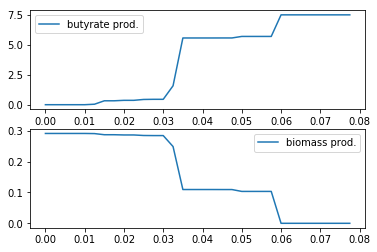

In [83]:
plt.subplot(2, 1, 1)
plt.plot(lams, buts, label = 'butyrate prod.')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(lams, biomasses, label = 'biomass prod.')
plt.legend()

plt.show()


### Gap Filling

https://cobrapy.readthedocs.io/en/latest/gapfilling.html

In [34]:
from cobra.flux_analysis import gapfill

In [35]:
universal = cobra.Model("universal_reactions")
cerevisiaeMod1.objective = cerevisiaeMod1.add_boundary(cerevisiaeMod1.metabolites.but_c, type='demand')

In [36]:
solution = gapfill(cerevisiaeMod1, universal)
for reaction in solution[0]:
    print(reaction.id)

In [37]:
solution

[[]]